In [1]:
import sys,os
from pathlib import Path

def add_dependencies():
    add_path = lambda path: sys.path.append(str(path))
    root_folder = Path(os.getcwd()).parent
    cryoem_folder = Path(root_folder, 'cryoem')
    cython_folder = Path(root_folder,'cryoem-cython-pyx')

    add_path(root_folder)
    add_path(cryoem_folder)
    add_path(Path(cryoem_folder,'util'))
    add_path(Path(cython_folder,'sincint'))
    add_path(Path(cython_folder,'sparsemul'))

add_dependencies()

In [2]:
from typing import List
import time

import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib as mpl
import matplotlib.pyplot as plt

from cryoem.cryoio import mrc
from cryoem.util import format_timedelta
from cryoem.cryoops import compute_premultiplier
from cryoem.density import real_to_fspace
from cryoem.snapshot import Snapshot


mpl.rcParams['figure.dpi'] = 300
plt.style.use(['dark_background'])

ERROR LOADING FFTW! USING NUMPY


In [3]:
# Custom types
from cryoem.cryoem import Density
Voxels = Density
'''Grid-like density in 3D'''
Pixels = Density
'''Grid-like density in 2D'''


'Grid-like density in 2D'

In [4]:
# Read the volume data and compute fft
wave_3d,hdr = mrc.readMRC("../data/cav_3d.mrc", inc_header=True)
# vol,hdr = mrc.readMRC("test_data/6ac9TeMet_denmod.mrc", inc_header=True)

boxSize = int(wave_3d.shape[0])
pxSize = (hdr['xlen']/hdr['nx'])

premult_1d = compute_premultiplier(boxSize, Snapshot.projection_opts['kern'], Snapshot.projection_opts['kernsize']) 
premult_3d = premult_1d[None,None] * premult_1d[None,:,None] * premult_1d[:,None,None]

spectral_wave_3d = real_to_fspace(premult_3d * wave_3d)

vol_f = fftshift(fft2(wave_3d))
wave_3d.max()

np.float32(39.041557)

In [5]:
from tqdm import tqdm

n_particles = 10
embedding = Snapshot.embedding(boxSize)

snapshots: List[Snapshot] = []
for _ in tqdm(range(n_particles)):
    snapshots.append(Snapshot(pixel_size=pxSize).generate_images(spectral_wave_3d, boxSize, embedding))
     
                          

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jovdoors/Folding/forked/cryoem-data-simulation/.venv/lib/python3.12/site-packages/numpy/_core/_asarray.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  return asanyarray(a, dtype=dtype)
100%|██████████| 10/10 [00:00<00:00, 35.80it/s]


In [6]:
output_folder = Path('..','output')
output_folder.mkdir(exist_ok=True)

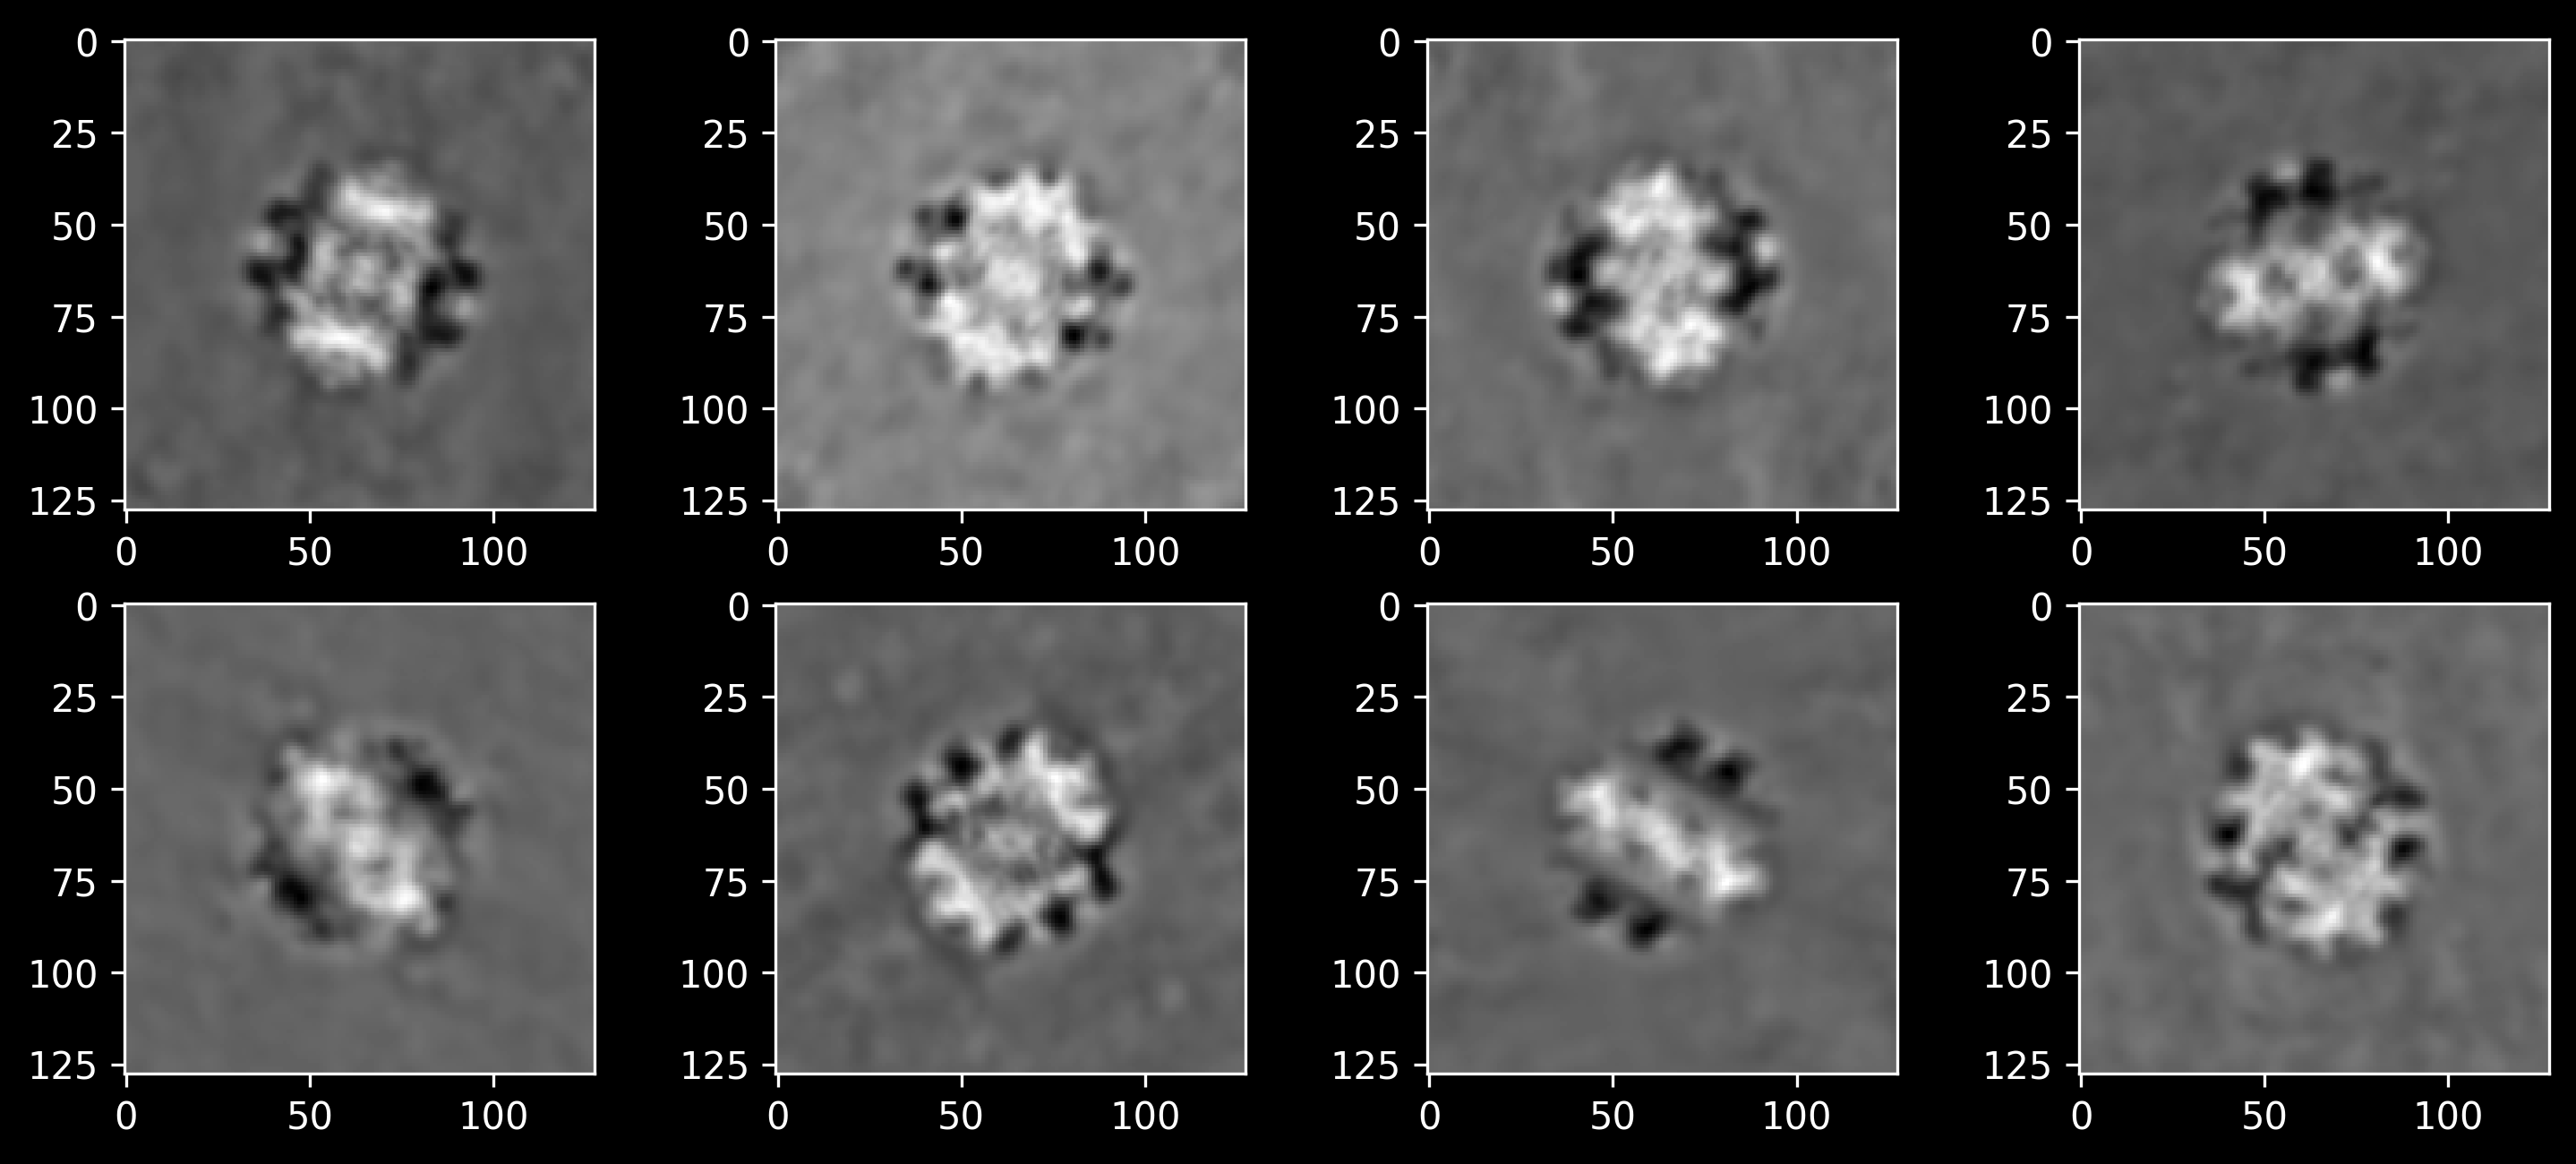

In [7]:
# Plot the first 8 images
fig,axes = plt.subplots(2,4,figsize=(12, 5))

for ax, snapshot in zip(axes.flatten(), snapshots):
    ax.imshow(snapshot.wave_2d, cmap='gray')
plt.savefig(Path(output_folder,'projections.png'))
plt.show()


In [8]:
# Write the particle stack
mrc.writeMRC(Path(output_folder,'simulated_particles.mrcs'), np.stack([s.wave_2d for s in snapshots],axis=-1), pxSize)

In [9]:
# Write the starfile
import starfile
import pandas as pd

def to_camel_case(text):
    return ''.join(word.capitalize() for word in text.split('_'))

star_path = Path(output_folder,'simulated_particles.star')
df = pd.DataFrame(snapshots)
df.columns = [f'rln{to_camel_case(col)} #{i}' for i,col in enumerate(df.columns,1)]
starfile.write(df, star_path)



In [10]:
df

,rlnAmpContrast #1,rlnPhi #2,rlnTheta #3,rlnPsi #4,rlnClassNumer #5,rlnAstigAngle #6,rlnDefocusA #7,rlnDefocusB #8,rlnPixelSize #9,rlnImageName #10,rlnMagnification #11,rlnOriginX #12,rlnOriginY #13,rlnPhaseShift #14,rlnSphericalAbberation #15,rlnVoltage #16
0,0.07,135.605418,145.109723,357.573935,1,180.650070,13967.196510,13775.036793,1.007812,1@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
1,0.07,128.488504,20.405210,12.958940,1,243.204523,12654.981231,12106.466216,1.007812,2@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
2,0.07,-71.147058,26.421493,28.198487,1,34.667457,14449.057058,14378.057957,1.007812,3@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
3,0.07,108.418126,143.146839,213.728397,1,227.105425,16000.171450,16600.521846,1.007812,4@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
4,0.07,163.033414,71.401334,101.042842,1,124.551896,17538.771086,16977.537170,1.007812,5@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
5,0.07,153.180839,158.995865,218.898952,1,90.895491,18296.491346,18252.229262,1.007812,6@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
6,0.07,92.396635,135.099611,245.470577,1,137.419033,13545.274671,14078.208649,1.007812,7@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
7,0.07,50.013217,106.216999,72.733404,1,253.187002,12845.465740,12413.504486,1.007812,8@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
8,0.07,12.679781,41.158602,358.323505,1,171.416711,14484.548303,14902.571551,1.007812,9@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
9,0.07,-16.831710,130.242463,301.809791,1,298.224445,11859.209229,12546.214523,1.007812,10@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
